<center> <img src=".github./images/MNIST.png" align="center"/>

# Projektna naloga pri predmetu TZ - Tehnologije Znanja
## Klasifikacija slik - ročno napisanih števk
* 60.000 števk
* 28×28 pikslov
* sivine
### Primerjava algoritmov nevronskih mrež s točnostmi, podanih na spletni strani
* Čas
* Število layerjev
* Število epoch
* Navzkrižna validacija
* Različni algoritmi
#### Podatki dostopni na  [MNIST Image Databse](http://yann.lecun.com/exdb/mnist/)

Najboljša zadeva pri reševanju "problema" MNIST je ta, da ne potrebujemo najbolšega računalnika na trgu, pravzaprav ne ptorebujemo niti grafične kartice. Modeli bi se naj s pomočjo CPUja v povprečju natrenirali približno v minuti, dejanske čase si bomo ogledali tekom tega doumenta. To raziskovalcu olajša delo, manj je čakanja, hkrati pa lahko eksperimentiramo z algoritmi, navzkrižno validacijo ipd.

Moj cilj je torej doseči čim večjo točnost v čim krajšem času. Primerjali bomo gole algoritme, večina njihovih parametrov bo nastavljena na privzete vrednosti.

#### Za delo potrebujemo različne knjižnice. V kolikor še niso nameščene, pred začetkom dela poženemo naslednje komande

In [ ]:
# pip install tensorflow
# pip install keras
# !pip install opencv-python

# pip install python-mnist # Če bi na drugačen način nalagali podatke

## idx3
Zaradi manjše velikosti so sličice podane v datoteki s končnico '.idx3-ubyte'

To je preprost format za shranjevanje vektorjev ter multi-dimenzionalnih matrik, ki vključujejo različne numerične tipe (spremenljivk).

Zato je prva naloga, da slikice iz te datoteke spravimo v berljivo obliko ter si jih ogledamo
* Slike za učenje so v mapi /train 
* Slike za testiranje so v mapi /test
_________________
Datoteke:
* train-images.idx3-ubyte
* train-labels.idx1-ubyte
* t10k-images.idx3-ubyte
* t10k-labels.idx1-ubyte
_________________

Primer zapisa slik v datoteko

| Offset | Type          | Value            | Description              |
|--------|---------------|------------------|--------------------------|
| 0000   | 32bit integer | 0x00000803(2051) | Magic Number (MSB first) |
| 0004   | 32bit integer | 60000            | No. of items             |
| 0008   | unsigned byte | 28               | No. of rows              |
| 00012  | unsigned byte | 28               | No. of columns           |
| 00016  |               | ??               | pixel                    |
| 00017  |               | ??               | pixel                    |
| ...    |               |                  |                          |
| xxxx   |               | ??               | pixel                    |

_________________
Primer zapisa labelov v datoteko

| Offset | Type          | Value            | Description              |
|--------|---------------|------------------|--------------------------|
| 0000   | 32bit integer | 0x00000801(2049) | Magic Number (MSB first) |
| 0004   | 32bit integer | 60000            | No. of items             |
| 0008   | unsigned byte | ??               | label                    |
| 0009   | unsigned byte | ??               | label                    |
| ...    |               |                  | label                    |
| xxxx   |               | ??               |                          |
The labels values are 0 to 9. 

*****
Oglejmo si našo kodo začnimo pri podatkih slikovnih datotek. Podobno kot s for zanko, gremo skozi datoteko. Prve 4 spremenljivke (razvidno iz tabele):
* Magic Number
* Velikost (Size)
* Število vrstic (nrows)
* Število stolpcev (ncols)

Vsaka naslednja pa predstavlja pixel 28*28 slike - 784 pikslov. Avtor je pokazal, da je takšna slika dovolj natančna, da predstavlja ročno napisano števko

Podoben začetek je pri labelih, prvi 2 vrstici predstavjata:
* Magic Number
* Velikost (Size)

Vsak naslednji vnos v datoteko pa je label slike, torej števka med 0 in 9

In [ ]:
import zipfile
from os import path

# če datoteka ne obstaja, unzip
if not path.exists("train/train-images.zip"):
    with zipfile.ZipFile("train/train-images.zip", "r") as zip_ref:
        zip_ref.extractall("train/")

In [ ]:
import numpy as np
import struct


def preberiDatoteke():
    with open("train/train-images.idx3-ubyte", "rb") as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        train_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder(">"))
        train_data = train_data.reshape((size, nrows, ncols))

    with open("train/train-labels.idx1-ubyte", "rb") as i:
        magic, size = struct.unpack(">II", i.read(8))
        train_data_labels = np.fromfile(i, dtype=np.dtype(np.uint8)).newbyteorder(">")

    with open("test/t10k-images.idx3-ubyte", "rb") as j:
        magic, size = struct.unpack(">II", j.read(8))
        nrows, ncols = struct.unpack(">II", j.read(8))
        test_data = np.fromfile(j, dtype=np.dtype(np.uint8).newbyteorder(">"))
        test_data = test_data.reshape((size, nrows, ncols))

    with open("test/t10k-labels.idx1-ubyte", "rb") as k:
        magic, size = struct.unpack(">II", k.read(8))
        test_data_labels = np.fromfile(k, dtype=np.dtype(np.uint8)).newbyteorder(">")

    return train_data, train_data_labels, test_data, test_data_labels


(
    train_data,
    train_data_labels,
    test_data,
    test_data_labels,
) = preberiDatoteke()  # Teh ne spreminjamo, da lahko kasneje ponastavimo
x_train, y_train, x_test, y_test = preberiDatoteke()  # Na teh izvajamo naše operacije

print("Število učnih slik:%8s" % str(len(x_train)))
print("Št. testnih slik:%10s" % str(len(x_test)))
print("Št. učnih labelov:%9s" % str(len(y_train)))
print("Št. test labelov:%10s" % str(len(y_test)))

## Dataset
Ti podatki so se veliko uporabljali, omogočajo različne vključitve v kodo

Kot zanimivost si oglejmo velikosti arhivov ter velikost datotek po tem, ko jih odpakiramo
* 9681 KB --> 45938 KB Slike Train
* 1611 KB --> 7657 KB Slike Test
* 29 KB --> 59 KB Labels Train
* 5 KB --> 10 Labels Test

Opazimo ~4-5kratno razliko

Ravno zaradi popularnosti tega dataseta obstaja mnogo različnih načinov nalaganja podatkov, eden izmed najbolj preprostih je knjižnica python-mnist, ki nam podatke sama poda v spremenljivke 
* xtrain, ytrain, xtest, ytest

# Več možnosti nalaganja dataseta
* Obstaja knjižnica mnist
* Zaradi popularnosti je ta set vključen v TensorFlow
* Prenso datotek s pomočjo wget

In [ ]:
# pip install python-mnist
## example of loading the mnist dataset
# from keras.datasets import mnist
# from matplotlib import pyplot
## load dataset
# (trainX, trainy), (testX, testy) = mnist.load_data()

In [ ]:
# import tensorflow as tf
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
# !wget -O data/train-images-idx3-ubyte.gz http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
# !wget -O data/train-labels-idx1-ubyte.gz http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
# !wget -O data/t10k-images-idx3-ubyte.gz http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
# !wget -O data/t10k-labels-idx1-ubyte.gz http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

### Da potrdimo pravilno naložene podatke ter si jih hkrati vizualiziramo, uporabim knjižnico matplotlib

In [ ]:
# Primer števil iz dataseta
import matplotlib.pyplot as plt

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_data[i, :, :], cmap="gray")
    plt.title(train_data_labels[i])
plt.show()

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_data[i, :, :], cmap=plt.cm.binary)
    plt.title(train_data_labels[i])
plt.show()

### Vidimo bele števke na črni podlagi. Kljub temu pa lahko uporabimo drugačne barve za njihov prikaz.

In [ ]:
plt.figure()
plt.imshow(train_data[59999])  # Vnesemo poljubno št med 0 in 59.999
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(x_train[i, :, :])
    plt.title(y_train[i])
    plt.axis("off")

In [ ]:
print("Train: X=%s, Y=%s" % (x_train.shape, y_train.shape))
print("Test:  x=%s, y=%s" % (x_test.shape, y_test.shape))

## Ogled poljubne slike in labela iz učne množice
### Števko si lahko vizualiziramo na mnogo načinov, nekaj primerov je podanih spodaj (cmap='barvniFilter')

In [ ]:
image_index = 1  # Vnesemo poljubno št med 0 in 59.999
print(train_data_labels[image_index])
# plt.imshow(train_data[image_index], cmap='Accent_r')
# plt.imshow(train_data[image_index], cmap='flag')
plt.imshow(train_data[image_index], cmap="summer")
# plt.imshow(train_data[image_index], cmap='winter')
# plt.imshow(train_data[image_index], cmap='Dark2')

In [ ]:
input_shape = (28, 28, 1)


def ponastaviPodatke(train_data, train_data_labels, test_data, test_data_labels):
    x_train, y_train, x_test, y_test = (
        train_data,
        train_data_labels,
        test_data,
        test_data_labels,
    )
    # Preoblikovanje arrayev v 4-dimenzije, saj Keras sprejema takšne podatke
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    # Vrednosti morajo biti tipa float, da lahko po delitvi - standardizaciji pridobimo decimalne vrednosti
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    # Normaliziramo - Standardiziramo RGB zapis slike, delimo z maksimalno vrednostjo RGB, kar je 255
    # Standardizacija slike - vrednosti v arrayu med števila 0-1
    x_train /= 255
    x_test /= 255
    return x_train, y_train, x_test, y_test

In [ ]:
# Importanje potrebnih modulov za tensorflow, Keras, potrebne layerje ipd.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import SGD
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import time
import pandas as pd
import cv2 as cv
from IPython.display import Image, display

## Sestava modela 
Moj plan je bil sestavo modela prikazati s sliko, ki je ustvarjena s pomočjo tf.keras.utils.plot_model() funkcije, vendar zaradi buga ne dela. Prav tako StackOverFlow nima rešitve, ki bi delovala pri meni.

In [ ]:
# Sestavimo model Nevronske Mreže
def SestaviModelKFold():
    # Sekvenčni model - Po definiciji iz Keras odkumentacije je to linearen sklad slojev. To pomeni, da gredo naši podatki skozi sloje po vrstnem redu, tako, kot smo jih dodajali
    modelKFold = Sequential()
    modelKFold.add(
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            input_shape=input_shape,
        )
    )
    modelKFold.add(MaxPooling2D((2, 2)))
    modelKFold.add(Flatten())  # Sploščitev slojev, za boljšo povezavo med njimi
    modelKFold.add(Dense(100, activation="relu", kernel_initializer="he_uniform"))
    modelKFold.add(Dense(10, activation="softmax"))
    return modelKFold

# Optimizatorji 
Keras ima različne možnosti, najpogosteje pa se uporablja 'adam'. V naslednjem primeru bom uporabil SGD - Stochastic gradient descent, ki dobro deluje na plitvih nevronskih mrežah

Dodatno mu dodamo še 'nesterov=True', Nesterov momentum oziroma NAG - Nesterov accelerated gradient. Kaj to sploh je?

Momentum upošteva pretekle naklone - gradiente v račun, na podlagi česar izravnava korake med spuščanjem gradienta.

In [ ]:
# Dodamo optimizator
opt = SGD(lr=0.01, momentum=0.9, nesterov=True)

modelKFold = SestaviModelKFold()
modelKFold.summary()

# Skompiliramo model
modelKFold.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# ocenitev našega modela na podlagi k-fold kros-validacije (k-fold cross-validation)
n_folds = 5  # "Poljubno" nastavi
epochsKFold = 2  # "Poljubno" nastavi
scores = list()
histories = list()

x_train, y_train, x_test, y_test = ponastaviPodatke(
    train_data, train_data_labels, test_data, test_data_labels
)

Ytrain = tf.keras.utils.to_categorical(y_train)
Ytest = tf.keras.utils.to_categorical(y_test)

kfold = KFold(n_folds, shuffle=True, random_state=1)
# Zmerimo čas
CasZacetek = time.time()
# razdelimo množice, navzkrižna validacija
for train_x, test_x in kfold.split(x_train):
    trainX = x_train[train_x]
    trainY = Ytrain[train_x]
    testX = x_train[test_x]
    testY = Ytrain[test_x]
    # natreniramo model v vsaki iteraciji for zanke znova
    history = modelKFold.fit(
        trainX,
        trainY,
        epochs=epochsKFold,
        batch_size=32,
        validation_data=(testX, testY),
        verbose=0,
    )
    _, acc = modelKFold.evaluate(testX, testY, verbose=0)
    print("> %.3f" % (acc * 100.0))
    scores.append(acc)
    histories.append(history)

print(
    "Točnost - accuracy: mean=%.3f std=%.3f, n_folds=%d"
    % (mean(scores) * 100, std(scores) * 100, n_folds)
)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek
podatki = {
    "Ime": ["ModelKFold"],
    "Tocnost": mean(scores) * 100,
    "Loss": mean(history.history["loss"]) * 100,
    "Cas": [trajanje],
    "Conv2D": [1],
}

df = pd.DataFrame(data=podatki)
df

> 97.725
> 99.008
> 99.158
> 99.700
> 99.792
Točnost - accuracy: mean=99.077 std=0.740, n_folds=5


,Ime,Tocnost,Loss,Cas,Conv2D
0,ModelKFold,99.076666,0.680525,138.868897,1


## Model.fit
Keras pri funkciji fit hrani določene parametre, ki pa jih lahko tudi nastavljamo. V našem primeru imamo samo privzete, ki si jih lahko ogledamo s pomočjo: 
* print(history.history.keys())

Privzeto vključuje:
*   acc
*   loss
*   val_acc
*   val_loss

Zadevo lahko vizualiziramo za vsak model, vsako epocho, kar je prikazano v nadaljevanju. Ker pa se tokrat v nastavljanje parametrov algoritma ne spuščam, si bomo kasneje ogledali le povprečne vrednosti v skupnem grafu.

In [ ]:
print(history.history.keys())
# print((history.history['loss']))
# print(mean(history.history['loss'])) # povprečje nad podatki v arrayu

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


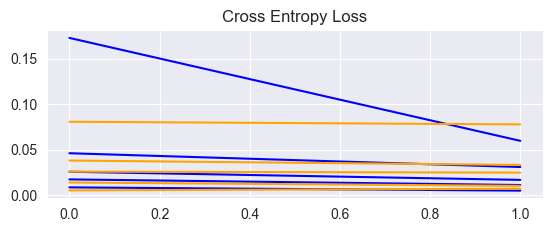

In [ ]:
for i in range(len(histories)):
    # Graf lossa
    plt.subplot(2, 1, 1)
    plt.title("Cross Entropy Loss")
    plt.plot(histories[i].history["loss"], color="blue", label="train")
    plt.plot(histories[i].history["val_loss"], color="orange", label="test")

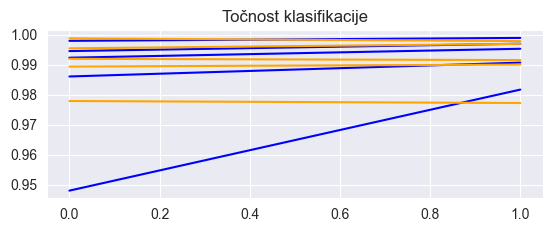

In [ ]:
for i in range(len(histories)):
    # Graf točnsti
    plt.subplot(2, 1, 2)
    plt.title("Točnost klasifikacije")
    plt.plot(histories[i].history["accuracy"], color="blue", label="train")
    plt.plot(histories[i].history["val_accuracy"], color="orange", label="test")

## Predikcija poljubnega podatka (s pomočjo KFold modela)

1/1 [==============================] - 0s 101ms/step
Napovedana: 8 Dejanska: 8


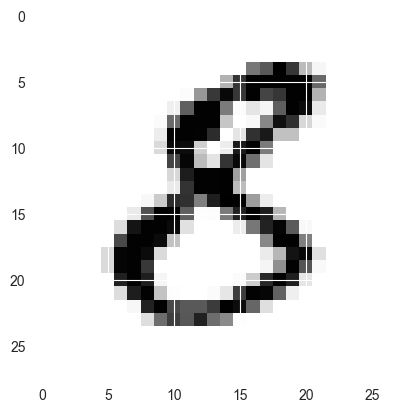

In [ ]:
indeks_stevila = 1234  # Poljubno vstavi število med 0-9999
plt.imshow(x_test[indeks_stevila].reshape(28, 28), cmap="Greys")
pred = modelKFold.predict(
    x_test[indeks_stevila].reshape(1, 28, 28, 1)
)  # Predickija števila
print(
    "Napovedana: " + str(pred.argmax()) + " Dejanska: " + str(y_test[indeks_stevila])
)  # Izpise napovedano vrednost ter dejansko vrednost

### Nastavitev epoch za vse naslednje modele

In [60]:
epochs = 3  # "Poljubno" nastavimo število epoch za vse vnaprej
index_columns = ["Ime", "Tocnost", "Loss", "Cas(sekunde)", "Conv2D"]

In [61]:
x_train, y_train, x_test, y_test = ponastaviPodatke(
    train_data, train_data_labels, test_data, test_data_labels
)

modelPrvi = Sequential()
modelPrvi.add(Conv2D(28, kernel_size=(3, 3), input_shape=input_shape))
modelPrvi.add(MaxPooling2D(pool_size=(2, 2)))
modelPrvi.add(Flatten())
modelPrvi.add(Dense(128, activation=tf.nn.relu))
modelPrvi.add(Dropout(0.2))
modelPrvi.add(Dense(10, activation=tf.nn.softmax))

modelPrvi.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

CasZacetek = time.time()  # čas "Štoparice" si zapišemo na začetku - trenutni čas

history2 = modelPrvi.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=0,
)  # Shranimo podatke fita

tocnost2 = history2.history[
    "accuracy"
]  # Iz podatkov vzamemo nam zanimiva 'accuracy' - tocnost
loss2 = history2.history["loss"]  # in loss modela

CasKonec = time.time()  # čas "Štoparice" si zapišemo še na koncu
trajanje = (
    CasKonec - CasZacetek
)  # Končnemu času odštejemo začetnega - razlika med njima je trajanje učenja

dodaj_vrstico = {
    "Ime": "ModelPrvi",
    "Tocnost": mean(tocnost2) * 100,
    "Loss": mean(loss2) * 100,
    "Cas(sekunde)": trajanje,
    "Conv2D": 1,
}  # Kreiranje vrstice za v dataframe
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe
df  # izpis dataframea

,Ime,Tocnost,Loss,Cas,Conv2D,Cas(sekunde),0
0,ModelKFold,99.076666,0.680525,138.868897,1.0,NaN,NaN
1,ModelPrvi,96.414999,11.774512,64.849707,1.0,NaN,NaN
2,modelKFoldBatch,97.272221,9.046794,61.129996,1.0,NaN,NaN
3,model2xConv,97.884442,6.851613,71.843560,2.0,NaN,NaN
4,model3xConv,97.943332,6.590625,129.653715,3.0,NaN,NaN
5,model4xConv,97.197777,8.938656,128.248143,4.0,NaN,NaN
6,LogisticRegression,92.550000,0.000000,NaN,0.0,32.525981,NaN
7,PassiveAggressiveClassifier,88.110000,NaN,14.405229,0.0,NaN,NaN
8,LarsCV,41.275062,NaN,NaN,0.0,4.042523,NaN
9,RidgeCV,62.385569,NaN,NaN,0.0,8.328911,NaN


#### Ena izmed lepših stvari v Pythonu je ta, da lahko model ocenimo s pomočjo ene vrstice kode. Obstaja seveda še veliko drugih metod

In [ ]:
predictions = modelPrvi.predict(x_test)
n = 2  # Poljubno vstavi vrednost med 0 in 9.999
print("Napovedana: " + str(np.argmax(predictions[n])) + " Dejanska: " + str(y_test[n]))

313/313 [==============================] - 1s 4ms/step
Napovedana: 1 Dejanska: 1


In [ ]:
print("Loss in Točnost modela 'ModelPrvi'")
modelPrvi.evaluate(x_test, y_test)

Loss in Točnost modela 'ModelPrvi'
313/313 [==============================] - 1s 4ms/step - loss: 0.0507 - accuracy: 0.9836


[0.050684068351984024, 0.9836000204086304]

## Batch Normalization
Je tehnika, ki avtomatsko standardizira vhodne podatke naslednjemu sloju v globoki nevronski mreži. 

Po implementaciji nam pohitri proces učenja, v nekaterih primerih pa malenkost izboljša točnost modela

In [ ]:
from keras.layers import BatchNormalization


def UstvariModelKFoldBatch():
    # Sestavimo model Nevronske Mreže
    ModelKFoldBatch = Sequential()
    ModelKFoldBatch.add(BatchNormalization())
    ModelKFoldBatch.add(
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            input_shape=input_shape,
        )
    )
    ModelKFoldBatch.add(MaxPooling2D((2, 2)))
    ModelKFoldBatch.add(Flatten())
    ModelKFoldBatch.add(Dense(100, activation="relu", kernel_initializer="he_uniform"))
    ModelKFoldBatch.add(BatchNormalization())
    ModelKFoldBatch.add(Dense(10, activation="softmax"))
    return ModelKFoldBatch

In [62]:
ModelKFoldBatch = UstvariModelKFoldBatch()
opt = SGD(learning_rate=0.01, momentum=0.9)
ModelKFoldBatch.compile(
    optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
x_train, y_train, x_test, y_test = ponastaviPodatke(
    train_data, train_data_labels, test_data, test_data_labels
)

CasZacetek = time.time()
history3 = ModelKFoldBatch.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=0,
)
tocnost3 = history3.history["accuracy"]
loss3 = history3.history["loss"]

CasKonec = time.time()
trajanje = CasKonec - CasZacetek

dodaj_vrstico = {
    "Ime": "modelKFoldBatch",
    "Tocnost": mean(tocnost3) * 100,
    "Loss": mean(loss3) * 100,
    "Cas": trajanje,
    "Conv2D": 1,
}
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe
df

,Ime,Tocnost,Loss,Cas,Conv2D,Cas(sekunde),0
0,ModelKFold,99.076666,0.680525,138.868897,1.0,NaN,NaN
1,ModelPrvi,96.414999,11.774512,64.849707,1.0,NaN,NaN
2,modelKFoldBatch,97.272221,9.046794,61.129996,1.0,NaN,NaN
3,model2xConv,97.884442,6.851613,71.843560,2.0,NaN,NaN
4,model3xConv,97.943332,6.590625,129.653715,3.0,NaN,NaN
5,model4xConv,97.197777,8.938656,128.248143,4.0,NaN,NaN
6,LogisticRegression,92.550000,0.000000,NaN,0.0,32.525981,NaN
7,PassiveAggressiveClassifier,88.110000,NaN,14.405229,0.0,NaN,NaN
8,LarsCV,41.275062,NaN,NaN,0.0,4.042523,NaN
9,RidgeCV,62.385569,NaN,NaN,0.0,8.328911,NaN


In [ ]:
def UstvariModel2xConv():
    model2Conv = Sequential()
    model2Conv.add(
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            input_shape=(28, 28, 1),
        )
    )
    model2Conv.add(MaxPooling2D((2, 2)))
    model2Conv.add(
        Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_uniform")
    )
    model2Conv.add(MaxPooling2D((2, 2)))
    model2Conv.add(Flatten())
    model2Conv.add(Dense(100, activation="relu", kernel_initializer="he_uniform"))
    model2Conv.add(Dense(10, activation="softmax"))
    return model2Conv

In [63]:
model2Conv = UstvariModel2xConv()
opt = SGD(learning_rate=0.01, momentum=0.9)
model2Conv.compile(
    optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
x_train, y_train, x_test, y_test = ponastaviPodatke(
    train_data, train_data_labels, test_data, test_data_labels
)

CasZacetek = time.time()

history4 = model2Conv.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=0,
)
tocnost4 = history4.history["accuracy"]
loss4 = history4.history["loss"]

CasKonec = time.time()
trajanje = CasKonec - CasZacetek

dodaj_vrstico = {
    "Ime": "model2xConv",
    "Tocnost": mean(tocnost4) * 100,
    "Loss": mean(loss4) * 100,
    "Cas": trajanje,
    "Conv2D": 2,
}
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe
df

,Ime,Tocnost,Loss,Cas,Conv2D,Cas(sekunde),0
0,ModelKFold,99.076666,0.680525,138.868897,1.0,NaN,NaN
1,ModelPrvi,96.414999,11.774512,64.849707,1.0,NaN,NaN
2,modelKFoldBatch,97.272221,9.046794,61.129996,1.0,NaN,NaN
3,model2xConv,97.884442,6.851613,71.843560,2.0,NaN,NaN
4,model3xConv,97.943332,6.590625,129.653715,3.0,NaN,NaN
5,model4xConv,97.197777,8.938656,128.248143,4.0,NaN,NaN
6,LogisticRegression,92.550000,0.000000,NaN,0.0,32.525981,NaN
7,PassiveAggressiveClassifier,88.110000,NaN,14.405229,0.0,NaN,NaN
8,LarsCV,41.275062,NaN,NaN,0.0,4.042523,NaN
9,RidgeCV,62.385569,NaN,NaN,0.0,8.328911,NaN


In [ ]:
def UstvariModelIzboljsan():
    model = Sequential()
    model.add(
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            input_shape=(28, 28, 1),
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_uniform"))
    model.add(Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_uniform"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation="relu", kernel_initializer="he_uniform"))
    model.add(Dense(10, activation="softmax"))
    return model

In [64]:
modelIzboljsan = UstvariModelIzboljsan()
opt = SGD(learning_rate=0.01, momentum=0.9)
modelIzboljsan.compile(
    optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
x_train, y_train, x_test, y_test = ponastaviPodatke(
    train_data, train_data_labels, test_data, test_data_labels
)

CasZacetek = time.time()

history5 = modelIzboljsan.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=0,
)
tocnost5 = history5.history["accuracy"]
loss5 = history5.history["loss"]

CasKonec = time.time()
trajanje = CasKonec - CasZacetek

dodaj_vrstico = {
    "Ime": "model3xConv",
    "Tocnost": mean(tocnost5) * 100,
    "Loss": mean(loss5) * 100,
    "Cas": trajanje,
    "Conv2D": 3,
}
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe
df

,Ime,Tocnost,Loss,Cas,Conv2D,Cas(sekunde),0
0,ModelKFold,99.076666,0.680525,138.868897,1.0,NaN,NaN
1,ModelPrvi,96.414999,11.774512,64.849707,1.0,NaN,NaN
2,modelKFoldBatch,97.272221,9.046794,61.129996,1.0,NaN,NaN
3,model2xConv,97.884442,6.851613,71.843560,2.0,NaN,NaN
4,model3xConv,97.943332,6.590625,129.653715,3.0,NaN,NaN
5,model4xConv,97.197777,8.938656,128.248143,4.0,NaN,NaN
6,LogisticRegression,92.550000,0.000000,NaN,0.0,32.525981,NaN
7,PassiveAggressiveClassifier,88.110000,NaN,14.405229,0.0,NaN,NaN
8,LarsCV,41.275062,NaN,NaN,0.0,4.042523,NaN
9,RidgeCV,62.385569,NaN,NaN,0.0,8.328911,NaN


In [ ]:
def UstvariModel4xConv():
    Model4xConv = Sequential()
    Model4xConv.add(
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            input_shape=(28, 28, 1),
        )
    )
    Model4xConv.add(MaxPooling2D((2, 2)))
    Model4xConv.add(
        Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_uniform")
    )
    Model4xConv.add(
        Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_uniform")
    )
    Model4xConv.add(MaxPooling2D((2, 2)))
    Model4xConv.add(
        Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_uniform")
    )
    Model4xConv.add(MaxPooling2D((2, 2)))
    Model4xConv.add(Flatten())
    Model4xConv.add(Dense(100, activation="relu", kernel_initializer="he_uniform"))
    Model4xConv.add(Dense(10, activation="softmax"))
    return Model4xConv

In [65]:
Model4xConv = UstvariModel4xConv()
opt = SGD(learning_rate=0.01, momentum=0.9)
Model4xConv.compile(
    optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
x_train, y_train, x_test, y_test = ponastaviPodatke(
    train_data, train_data_labels, test_data, test_data_labels
)

CasZacetek = time.time()

history6 = Model4xConv.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=0,
)
tocnost6 = history6.history["accuracy"]
loss6 = history6.history["loss"]

CasKonec = time.time()
trajanje = CasKonec - CasZacetek

dodaj_vrstico = {
    "Ime": "model4xConv",
    "Tocnost": mean(tocnost6) * 100,
    "Loss": mean(loss6) * 100,
    "Cas": trajanje,
    "Conv2D": 4,
}
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe
df

,Ime,Tocnost,Loss,Cas,Conv2D,Cas(sekunde),0
0,ModelKFold,99.076666,0.680525,138.868897,1.0,NaN,NaN
1,ModelPrvi,96.414999,11.774512,64.849707,1.0,NaN,NaN
2,modelKFoldBatch,97.272221,9.046794,61.129996,1.0,NaN,NaN
3,model2xConv,97.884442,6.851613,71.843560,2.0,NaN,NaN
4,model3xConv,97.943332,6.590625,129.653715,3.0,NaN,NaN
5,model4xConv,97.197777,8.938656,128.248143,4.0,NaN,NaN
6,LogisticRegression,92.550000,0.000000,NaN,0.0,32.525981,NaN
7,PassiveAggressiveClassifier,88.110000,NaN,14.405229,0.0,NaN,NaN
8,LarsCV,41.275062,NaN,NaN,0.0,4.042523,NaN
9,RidgeCV,62.385569,NaN,NaN,0.0,8.328911,NaN


<AxesSubplot: xlabel='Ime'>

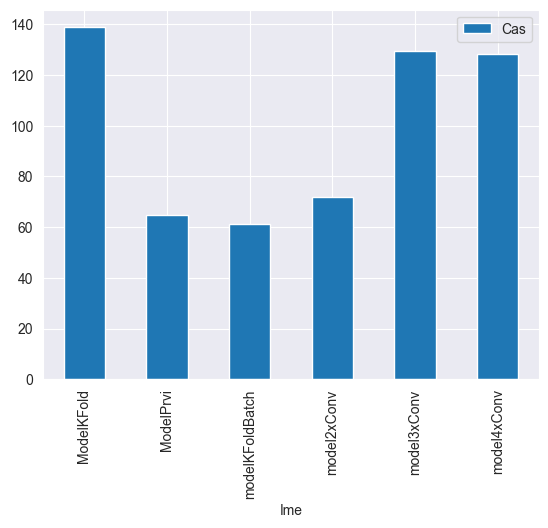

In [ ]:
df.plot(kind="bar", x="Ime", y="Cas")

<AxesSubplot: xlabel='Ime'>

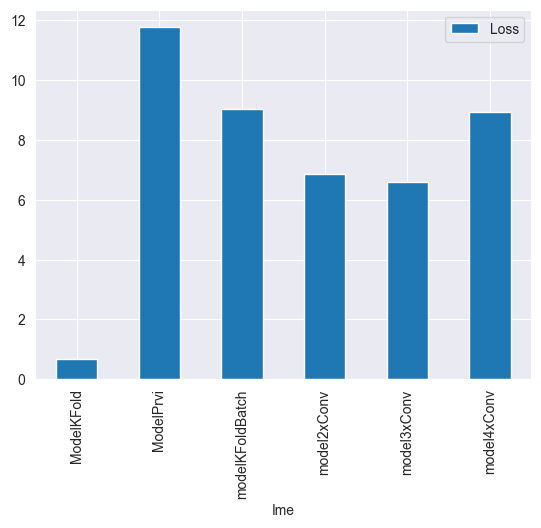

In [ ]:
df.plot(kind="bar", x="Ime", y="Loss")

<AxesSubplot: >

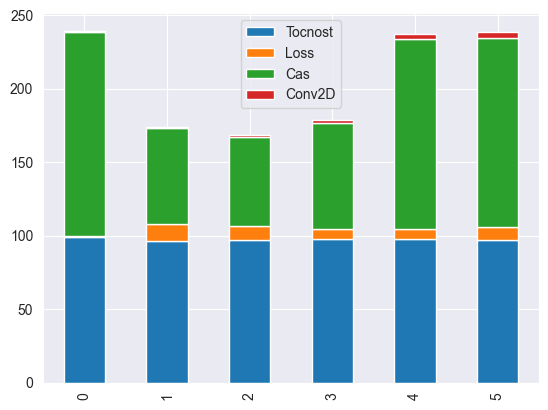

In [ ]:
df.plot(kind="bar", stacked=True)

# Uporaba Scikit Learn
Spet imamo veliko različnih možnosti nalaganja podatkov, nek manjši digit dataset ima tudi sklearn, ima pa okoli 1700 števk velikosti 8x8 pikslov.
Da bo primerjava realnejša, raje uporabim datoteko, ki jo že imam na disku.
## Naslednja metoda naredi podobno kot naša preberiDatoteke() 

Vendar na malenkost drugačen način zapiše datoteke v spremenljivke, zmanjša dimenzijo arraya, kar omogoči uporabo sk-learn knjižnice. Tukaj namreč potrebujemo maksimalno 2D array, pri nevronskih mrežah pa je bilo dimenzij več 

In [ ]:
from struct import unpack


def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, "rb")
    labels = open(labelfile, "rb")

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack(">I", number_of_images)[0]
    rows = images.read(4)
    rows = unpack(">I", rows)[0]
    cols = images.read(4)
    cols = unpack(">I", cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack(">I", N)[0]

    # Get data
    x = np.zeros((N, rows * cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows * cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack(">B", tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack(">B", tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

## Učna in testna množica
sedaj sem mali x in y zamenjal z velikim, podatki v množici so v bistvu enaki, le na drugačen način zabeleženi

In [ ]:
X_train, Y_train = loadmnist(
    "train/train-images.idx3-ubyte", "train/train-labels.idx1-ubyte"
)
X_test, Y_test = loadmnist("test/t10k-images.idx3-ubyte", "test/t10k-labels.idx1-ubyte")

In [66]:
from sklearn.linear_model import LogisticRegression

# solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
logisticRegr = LogisticRegression(solver="lbfgs")

CasZacetek = time.time()

logisticRegr.fit(X_train, Y_train)

tocnost7 = logisticRegr.score(X_test, Y_test)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek

dodaj_vrstico = {
    "Ime": "LogisticRegression",
    "Tocnost": mean(tocnost7) * 100,
    "Loss": 0,
    "Cas(sekunde)": trajanje,
    "Conv2D": 0,
}
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe
df.head(7)

C:\Users\Rok\PycharmProjects\MNIST-Recognizing-hand-written-digits\mnist_venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Ime,Tocnost,Loss,Cas,Conv2D,Cas(sekunde),0
0,ModelKFold,99.076666,0.680525,138.868897,1.0,NaN,NaN
1,ModelPrvi,96.414999,11.774512,64.849707,1.0,NaN,NaN
2,modelKFoldBatch,97.272221,9.046794,61.129996,1.0,NaN,NaN
3,model2xConv,97.884442,6.851613,71.843560,2.0,NaN,NaN
4,model3xConv,97.943332,6.590625,129.653715,3.0,NaN,NaN
5,model4xConv,97.197777,8.938656,128.248143,4.0,NaN,NaN
6,LogisticRegression,92.550000,0.000000,NaN,0.0,32.525981,NaN


Text(0.5, 1.0, 'Accuracy Score: 1')

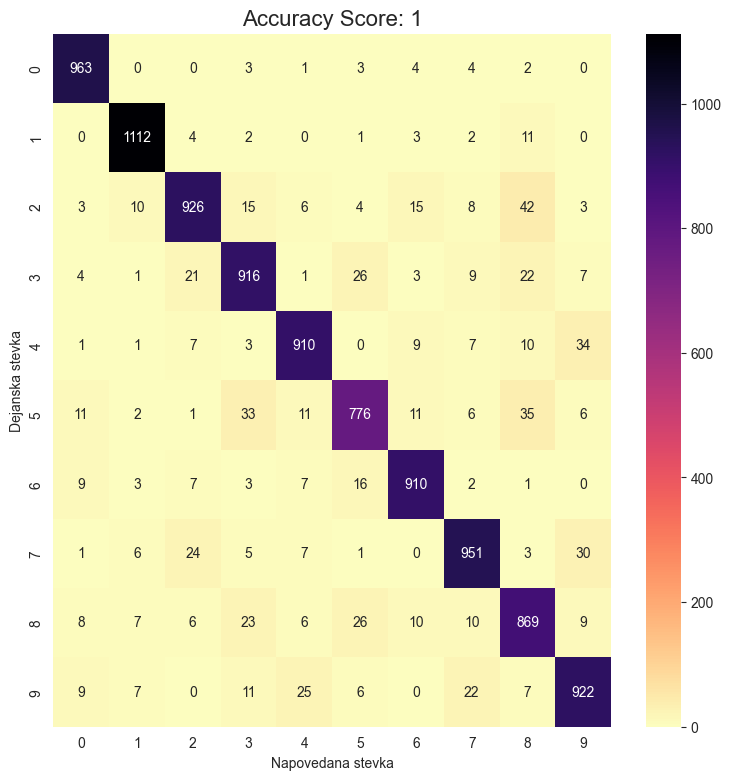

In [39]:
from sklearn import metrics
import seaborn as sns

napovej = logisticRegr.predict(X_test)
cm = metrics.confusion_matrix(Y_test, napovej)

plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="magma_r")
plt.xlabel("Napovedana stevka")
plt.ylabel("Dejanska stevka")
all_sample_title = "Accuracy Score: {:.0f}".format(tocnost7)
plt.title(all_sample_title, size=16)

## Zanimivost
Ena izmed bolj zanimiv zadev, ki sem jih zasledil, pa je vizualen prikaz števk, ki smo jih narobe napovedali

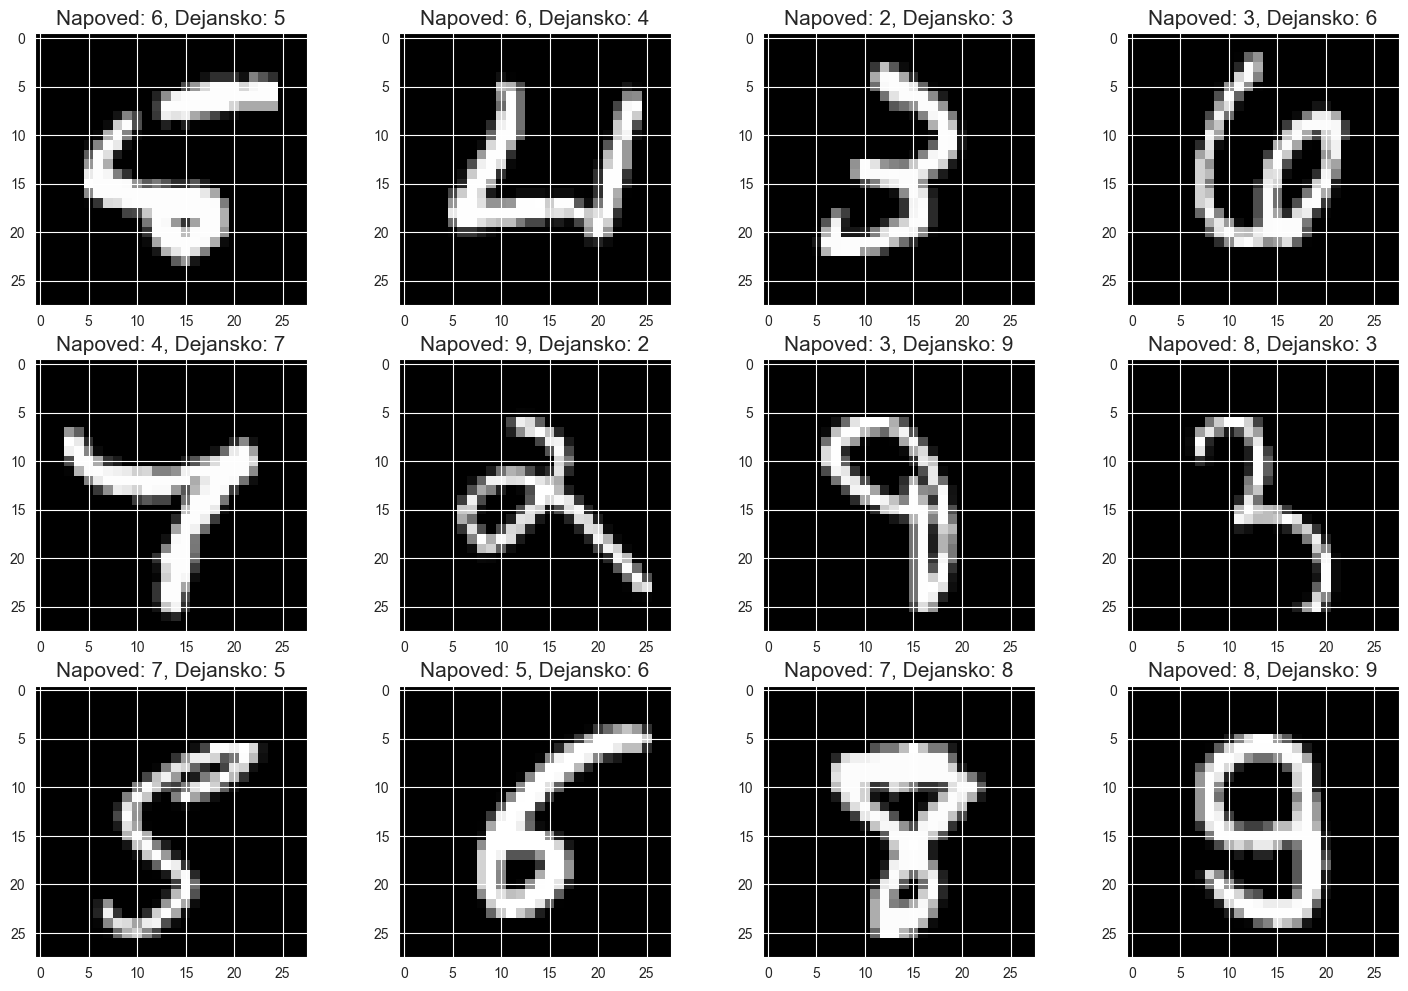

In [40]:
i = 0
nepravilne = []
for label, predict in zip(Y_test, napovej):
    if label != predict:
        nepravilne.append(i)
    i = i + 1

plt.figure(figsize=(18, 12))
for plotIndex, badIndex in enumerate(
    nepravilne[0:12]
):  # s for zanko se sprehodimo čez prvih dvanajst 0-11
    plt.subplot(
        3, 4, plotIndex + 1
    )  # subplot naredi več majnših grafov, prikazuje 3 vrstice in 4 stolpce sličic
    plt.imshow(
        np.reshape(X_test[badIndex], (28, 28)), cmap=plt.cm.gray
    )  # 28,28 je dejanska velikost slike
    plt.title(
        "Napoved: {}, Dejansko: {}".format(napovej[badIndex], Y_test[badIndex]),
        fontsize=15,
    )  # K vsaki sliki dodamo title bar, v katerega zapišemo dejansko vrednost števke ter vrednost, ki jo je naš LogisticRegression algoritem napovedal

## Komentar
Lahko vidimo, da števke ki so bile napačno napovedane, so večinoma res zmazki. Pri določenih takoj opazimo, kje se je algoritem zmotil. Spet drugje ni najbolj jasno zakaj je do tega prišlo.  

In [41]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac = PassiveAggressiveClassifier(max_iter=1000, random_state=0)

CasZacetek = time.time()

pac.fit(X_train, Y_train)

tocnost8 = pac.score(X_test, Y_test)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek

dodaj_vrstico = {
    "Ime": "PassiveAggressiveClassifier",
    "Tocnost": mean(tocnost8) * 100,
    "Cas": trajanje,
    "Conv2D": 0,
}
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe

C:\Users\Rok\AppData\Local\Temp\ipykernel_22120\724869429.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dodaj_vrstico, ignore_index=True)


In [42]:
from sklearn.linear_model import LarsCV

lCV = LarsCV()

CasZacetek = time.time()

lCV.fit(X_train, Y_train)

tocnost9 = lCV.score(X_test, Y_test)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek

dodaj_vrstico = {
    "Ime": "LarsCV",
    "Tocnost": mean(tocnost9) * 100,
    "Cas(sekunde)": trajanje,
    "Conv2D": 0,
}
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe

C:\Users\Rok\AppData\Local\Temp\ipykernel_22120\3111170837.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dodaj_vrstico, ignore_index=True)


In [43]:
from sklearn.linear_model import RidgeCV

rCV = RidgeCV()

CasZacetek = time.time()

rCV.fit(X_train, Y_train)

tocnost10 = rCV.score(X_test, Y_test)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek

dodaj_vrstico = {
    "Ime": "RidgeCV",
    "Tocnost": mean(tocnost10) * 100,
    "Cas(sekunde)": trajanje,
    "Conv2D": 0,
}
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe

C:\Users\Rok\AppData\Local\Temp\ipykernel_22120\3194634812.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dodaj_vrstico, ignore_index=True)


In [44]:
from sklearn.linear_model import ElasticNetCV

enCV = ElasticNetCV()

CasZacetek = time.time()

enCV.fit(X_train, Y_train)

tocnost11 = enCV.score(X_test, Y_test)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek

dodaj_vrstico = {
    "Ime": "ElasticNetCV",
    "Tocnost": mean(tocnost11) * 100,
    "Cas(sekunde)": trajanje,
    "Conv2D": 0,
}
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe

C:\Users\Rok\AppData\Local\Temp\ipykernel_22120\1175910350.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dodaj_vrstico, ignore_index=True)


In [45]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge()

CasZacetek = time.time()

br.fit(X_train, Y_train)

tocnost12 = br.score(X_test, Y_test)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek

dodaj_vrstico = {
    "Ime": "BayesianRidge",
    "Tocnost": mean(tocnost12) * 100,
    "Cas(sekunde)": trajanje,
    "Conv2D": 0,
}
dodaj_vrstico_series = pd.Series(data=dodaj_vrstico, index=index_columns)
df = pd.concat([df, dodaj_vrstico_series])  # Dodajanje vrstice v dataframe
df.tail(6)

C:\Users\Rok\AppData\Local\Temp\ipykernel_22120\3425851341.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dodaj_vrstico, ignore_index=True)


,Ime,Tocnost,Loss,Cas,Conv2D,Cas(sekunde)
6,LogisticRegression,92.550000,0.0,NaN,0,32.525981
7,PassiveAggressiveClassifier,88.110000,NaN,14.405229,0,NaN
8,LarsCV,41.275062,NaN,NaN,0,4.042523
9,RidgeCV,62.385569,NaN,NaN,0,8.328911
10,ElasticNetCV,62.613345,NaN,NaN,0,36.145140
11,BayesianRidge,62.618886,NaN,NaN,0,7.771200


# Zaključek

### Sproti v kodi imamo par spremenljivk, ki jih lahko nastavljamo ter malo preizkušamo naše algoritme, si kaj vizualiziramo. Bralcu priporočam, da to poišče s pomočjo iskanja (ctrl + f) besedice "poljubno"
### Zakaj 3 epoche?
Kot sem že na začetku zapisal, sem se osredotočil na čas in ne na najvišjo možno točnost. Izkazalo se je, da se modeli med prvimi tremi epochami največ naučijo, razlike so najbolj očitne. Kasneje so te vrednosti bistveno manjše, čas izvajanja algoritma pa se sorazmerno podaljša.

Sedaj vidimo, kako zelo natančne so nevronske mreže. Pa vendar nastopi problem, tudi če je natančnost 99.9%, to pomeni, da bi v primeru avtonomnih avtomobilov vsak tisoči naredil prometno nesrečo..

Točnosti časov algoritmov so sicer izmerjene za čas treniranja, vendar vsakič znova opažam velike razlike. Do tega pride preprosto zaradi tega, ker na operacijskem sistemu python ni edini proces, kljub temu, da sem se trudil imeti ostale programe zaprte. Na windowsu imamo torej obilico ostalih procesov, ki se izvajajo v okviru OS ter na njih skoraj nimamo vpliva.

Najbolj zanimiva je časovna primerjava nevronskih mrež, ki so vse zelo natančne z drugačno vrsto algoritmov. Tudi ti dosegajo dobro natačnost vendar v občutno krajšem času.
### Pojasnilo
ModelKFold uporablja navzkrižno (KFold) validacijo, modelKFoldBatch pa je enak model, dodana je Batch validacija, ni pa uporabljena navzkrižna validacija

<AxesSubplot: xlabel='Ime'>

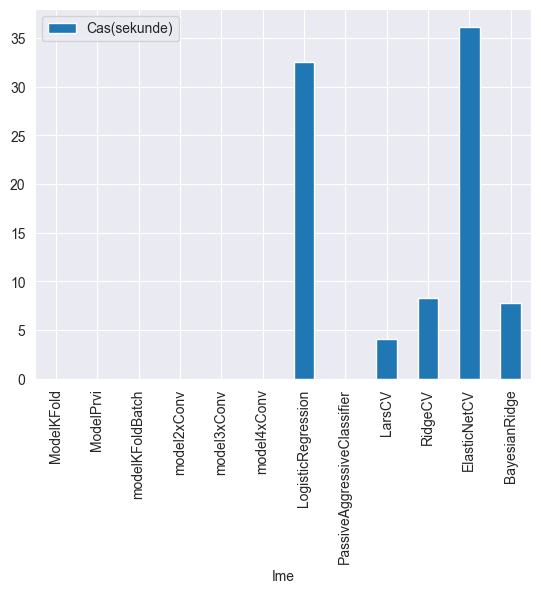

In [52]:
df.plot(kind="bar", x="Ime", y="Cas(sekunde)")

### Pri ogledu grafa razlike med točnostjo CNN ne opazimo, njihov čas je pa bistveno večji od Sk-learn. Vidimo, da Logistic Regression glede na porabljen čas dosega najboljše rezultate.

<AxesSubplot: xlabel='Ime'>

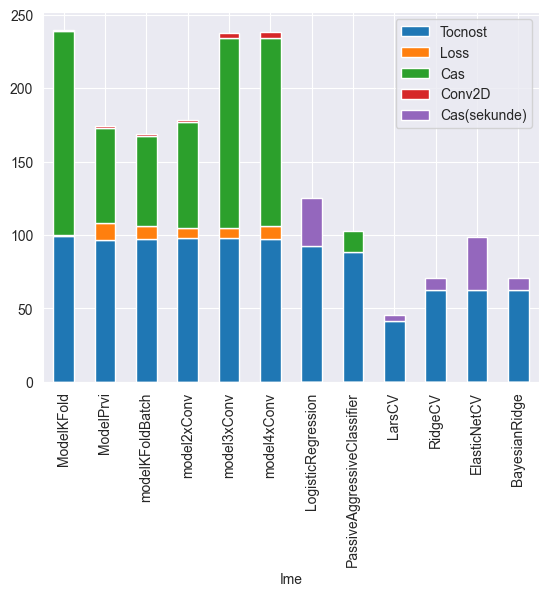

In [53]:
df.plot(kind="bar", stacked=True, x="Ime")

<AxesSubplot: xlabel='Ime'>

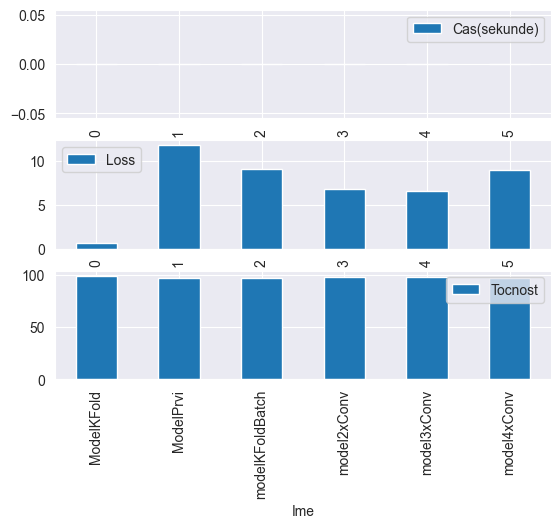

In [54]:
# Grafa prikazujeta točnosti in losse naših nevronskih mrež
fig, axes = plt.subplots(nrows=3, ncols=1)
df.iloc[:6].plot(ax=axes[0], kind="bar", y="Cas(sekunde)")
df.iloc[:6].plot(ax=axes[1], kind="bar", y="Loss")
df.iloc[:6].plot(ax=axes[2], kind="bar", x="Ime", y="Tocnost")

V prejšnjem grafu vidimo primerjavo časa, lossov ter tocnosti naših CNN, ki so se vse izkazale za odlične, točnosti so si torej tako podobne, da se jih z grafa ne da razločiti. Zanimiv pa je čas treniranja. Tako kot je pisalo v članku avtorja dataseta, potrebujemo nekje od cirka 1minute za fit.

<AxesSubplot: xlabel='Ime'>

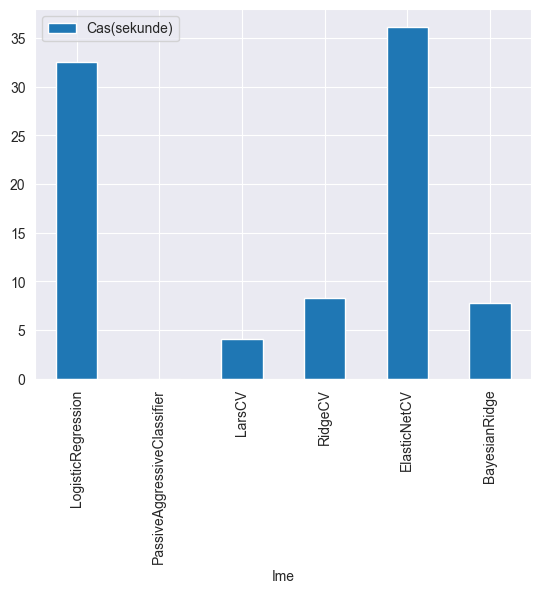

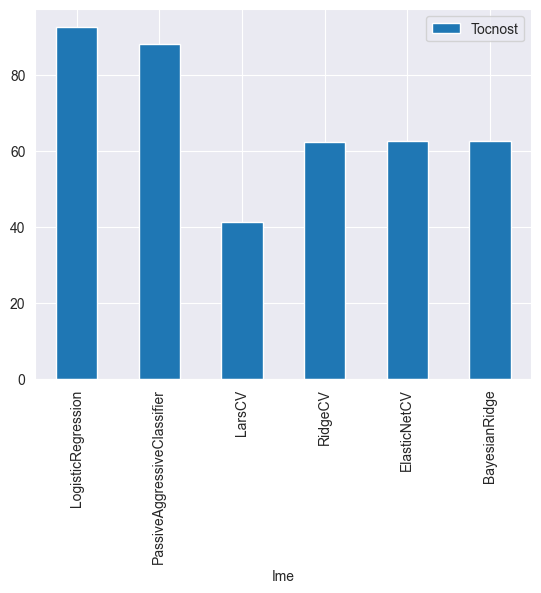

In [55]:
# Graf točnosti ScikitLearn algoritmov
df.iloc[6:].plot(kind="bar", x="Ime", y="Cas(sekunde)")
df.iloc[6:].plot(kind="bar", x="Ime", y="Tocnost")

## Komentar o SkLearn
Notebook sem večkrat zagnal, rezultati pa so večinoma enaki. LarsCV ima v našem primeru **najslabšo natančnost**, čas pa je nekje v povprečju. 

Za **najbolj točnega** se običajno izkaže LogisticREgression, pri čemer pa po času zasede 3. mesto.

**Daleč** največ časa porabi ElasticNetCV, njegova točnost pa je nekje okoli 3. mesta, ki si ga deli še z RidgeCV in BayesianRidge

# Napoved lastno zapisanih števk
Da pa ne bomo vsega prikazovali samo v teoriji na podlagi dataseta "z interneta", sem ustvaril svoj majhen testni dataset

Moje slike so tanko napisane z modro kulico na list papirja, slikane s telefonom, namenoma niso tako "lepe". Original slika je, kot dokazni material, priložena v mapi rocnoNapisaneStevke, vsako števko posebej pa sem iz slike izločil ter shranil v (28,28) pikslov, saj tako zmanjšam velikost celotnega projekta.

Knjižnica cv2 omogoča branje slik iz diska, s parametrom cv.IMREAD pa določamo barvno lestvico, npr. _UNCHANGED in _COLOR. Naš model je napoveal v sivinah, zato tudi mi našo sliko preberemo v sivinah. 

To omogoči, da lahko vsako števko, ne glede na to kako in kje je napisana, naš algoritem prebere, barve pa uredimo v kodi. Je pa res, da če bi imeli roza ozadje in rdečo števko, bi nastopil problem urejanja barv, saj niso v kontrastu.

In [56]:
def napovejRocnoNapisane(s):
    file = "hand-written-digits/" + str(s) + ".png"  # podamo datoteko
    image = cv.imread(
        file, cv.IMREAD_GRAYSCALE
    )  # preberemo datoteko kot sliko, pretvorimo v barvno lestvico sivin
    image = image.astype("float32")  # pretvorimo v tip float, s katero cnn zna delat
    image = image.reshape(1, 28, 28)  # shape slike - enak kot pri MNIST datasetu
    image = 255 - image  # Obrnemo barve
    # image = ~image # Obrnemo barve
    image = image / 255  # Normalizacija
    return image

Števka 0


Števka 1


Števka 2


Števka 3


Števka 4


Števka 5


Števka 6


Števka 7


Števka 8


Števka 9


Sledijo napovedi


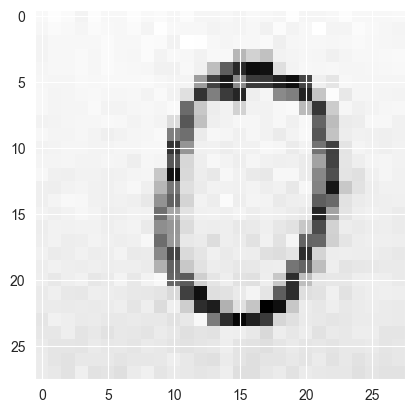

1/1 [==============================] - 0s 43ms/step
Napovedana: 0 Dejanska: 0


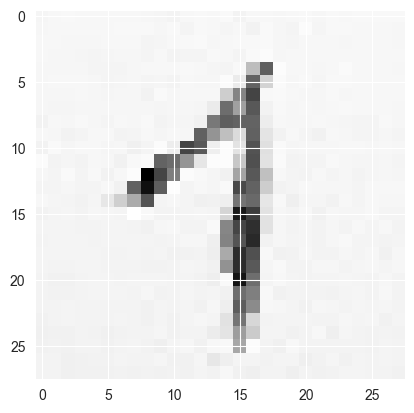

1/1 [==============================] - 0s 27ms/step
Napovedana: 4 Dejanska: 1


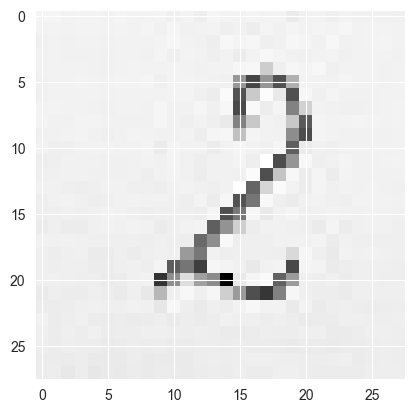

1/1 [==============================] - 0s 25ms/step
Napovedana: 2 Dejanska: 2


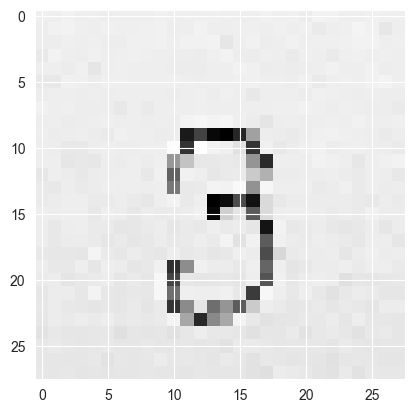

1/1 [==============================] - 0s 28ms/step
Napovedana: 5 Dejanska: 3


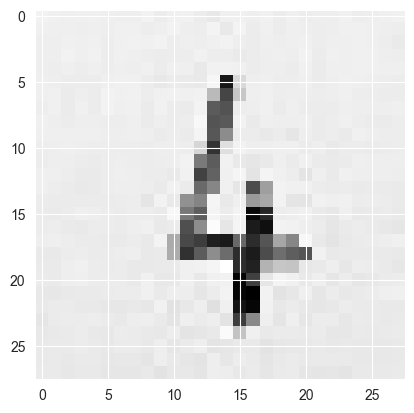

1/1 [==============================] - 0s 57ms/step
Napovedana: 4 Dejanska: 4


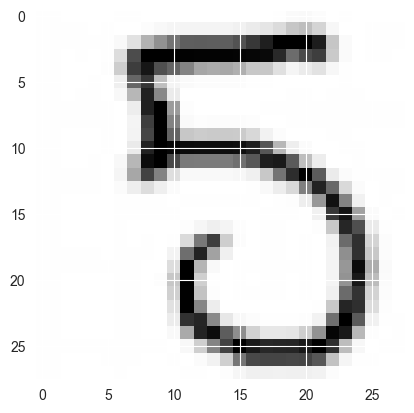

1/1 [==============================] - 0s 22ms/step
Napovedana: 5 Dejanska: 5


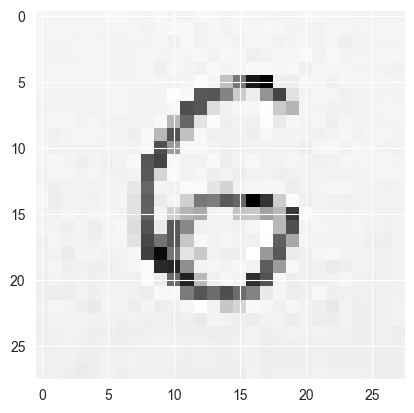

1/1 [==============================] - 0s 56ms/step
Napovedana: 6 Dejanska: 6


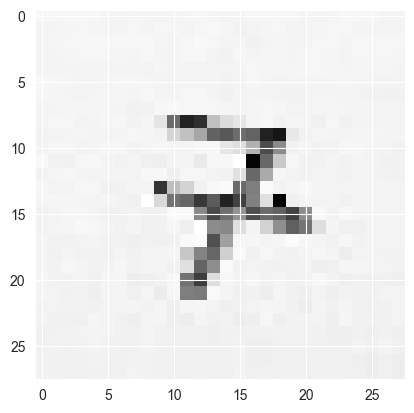

1/1 [==============================] - 0s 20ms/step
Napovedana: 7 Dejanska: 7


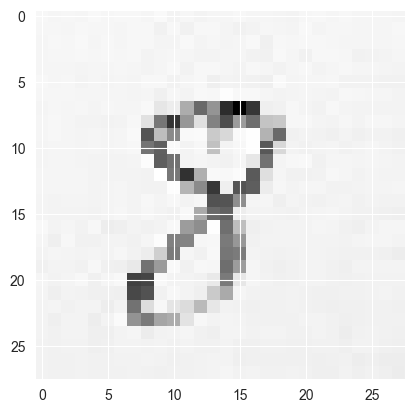

1/1 [==============================] - 0s 28ms/step
Napovedana: 8 Dejanska: 8


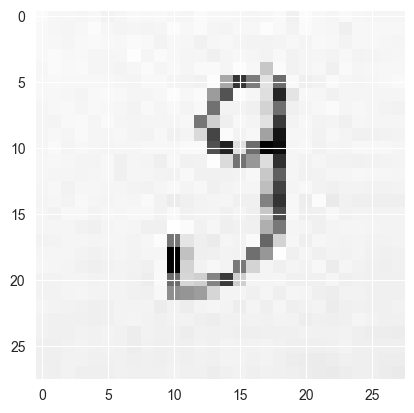

1/1 [==============================] - 0s 25ms/step
Napovedana: 0 Dejanska: 9


In [58]:
for s in range(10):
    print("Števka " + str(s))
    display(Image("hand-written-digits/" + str(s) + ".png", format="png"))

print("Sledijo napovedi")

for s in range(10):
    image = napovejRocnoNapisane(str(s))
    plt.imshow(image.reshape(28, 28), cmap="Greys")
    plt.show()
    pred = modelKFold.predict(image.reshape(1, 28, 28, 1))  # Predickija števila
    print(
        "Napovedana: " + str(pred.argmax()) + " Dejanska: " + str(s)
    )  # Izpise napovedano vrednost ter dejansko vrednost